
<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Using Dask to Scale Up Your Data Analysis
**ESDS 2024 Annual Event Xarray-Dask Tutorial | January 19th, 2023**  

Negin Sobhani and Brian Vanderwende  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

------

### In this tutorial, you will learn:

* Dask Fundamentals - Collections and Workers (25 mins)
* Using Dask Distributed to Scale Computations (30 mins)
* Optimizing and Debugging Dask (20 mins)


### Prerequisites
| Concepts | Importance |
| --- | --- |
| Familiarity with Xarray        | Necessary |
| Basic familiarity with NumPy	 | Necessary |
| Basic familiarity with Pandas	 | Helpful |
| Understanding of parallelism	 | Helpful |


- **Time to learn**: 80 minutes

<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/dask_horizontal.svg"
     width="500px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

## Dask enables task-based parallelism for Python data science

* Dask is an open-source Python library for parallel and distributed computing that scales the existing Python ecosystem.

* Dask was developed to scale Python packages such as Numpy, Pandas, and Xarray to multi-core machines and distributed clusters when datasets exceed memory.

### Why run in parallel at all?

* Parallelization allows you to operate on datasets that are too large to fit into the memory of a single system
* Task-based parallelism like Dask provides allows you to compute on multiple sections of your dataset in parallel, potentially achieving significant speedup!

Other methods for parallelism exist in Python, so...

### Why use Dask?

#### Familiar Interface
Dask provides interfaces which mimic commonly used Python data science APIs. Dask provides ways to parallelize Pandas, Xarray, and Numpy workflows with minimal code rewriting (no massive code-restructure or writing a script in another language).

#### Scalability
Dask allows the same code to scale up from a single workstation to an entire HPC cluster (100-1000x bigger), or even theoretically limitless scale in the cloud. Users can begin with their existing hardware and then add additional resources to handle increasingly large and complex datasets.

#### Flexibility
Dask functionality is broken into separate component packages, some of which are interchangeable depending on the use case. This allows Dask to provide seamless integration with well-known HPC resource managers and job scheduling systems, including PBS and Slurm, when needed.

#### Built-in Diagnostic Tools
Dask provides responsive feedback via the client as well as a real-time interactive diagnostic dashboard to keep users informed on how the computation is progressing. This helps users identify and resolve potential issues without waiting for the work to be completed. 

## Dask Fundamentals

### Dask Collections

When we run a data science computation, we are performing some operation on a dataset. For many operations, an easy way to parallelize the process is to split the data into multiple *chunks*.

In order to make this process easy, Dask provides **collections** which are chunked versions of popular data structures like Numpy arrays, Pandas dataframes, and even Python lists.

<div style="margin-left: 100px; margin-bottom: 30px; margin-top: 30px; font-style: italic;">
<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/dask-array.svg"
     width="600px"
     alt="Dask Arrays"/>
    
    Image credit: Anaconda, Inc. and contributors
</div>

And because Xarray can swap between Numpy arrays and Dask arrays as core data structure of a DataArray, Xarrays can be chunked Dask collections too!

#### Example collection - Xarray with multi-file datasets

Xarray provides the `open_mfdataset` method, which opens multiple files as a single Xarray dataset. This method will automatically create a Dask-based Xarray data structure if chunking is requested!

Let's examine a Dask Xarray collection. First, we can identify a list of files to read in using `open_mfdataset`. We will use the same LENS2 dataset as in the Xarray tutorial:

In [1]:
import os
import glob
import xarray as xr

var = 'TREFHT'

# find all LENS files for a single ensemble run
data_dir = os.path.join('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/', var)
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013*.nc'))

print("Number of input files: ", len(files), "files")

# Print the typical size of an input file
print("Size of input file:     {:.2f} MB".format(os.stat(files[0]).st_size / (1024 ** 2)))

Number of input files:  9 files
Size of input file:     14.17 MB


In [2]:
ds = xr.open_mfdataset(
    sorted(files),
    # concatenate along this dimension
    concat_dim="time",
    # concatenate files in the order provided
    combine="nested",
    # these are netCDF4 files, use the h5netcdf package to read them
    engine="h5netcdf",
    # hold off on decoding time
    decode_cf=False,
    # specify that data should be automatically chunked
    chunks="auto",
)

# Decode the dataset according to CF conventions (https://cfconventions.org/)
ds = xr.decode_cf(ds)

We can look at the *repr* (HTML representation) of a DataArray within the Xarray Dataset to see how the base data structure in the DataArray is now a Dask array. We also get basic information about chunk sizes:

In [3]:
ds.TREFHT

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<concatenate, shape=(1032, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

This representation can be particularly powerful, as it gives us information about the memory footprint of the entire Dask array as well as that of each chunk.

The sizes of each chunk can also be printed explicitly:

In [4]:
ds.TREFHT.chunks

((120, 120, 120, 120, 120, 120, 120, 120, 72), (192,), (288,))

* How many chunks do we have? 
* What is the size of each chunk size?

Here we can see that we have a total of 9 chunks - equal to the number of our netCDF files. In general `open_mfdataset` will return one chunk per netCDF file.

### Lazy evaluation and accessing collection data

Because parallel operations are often expensive in terms of CPU and memory requirements, Dask is built upon the idea of **lazy evaluation**. This means that data are not loaded into a collection and computations aren't performed on collections until absolutely necessary, or triggered manually by the user.

The data represented by the dataset above are not yet loaded into this notebook. Similar to *Pandas*, Dask loads just enough data to give you information about the collection. There are many ways to trigger computation, including simply printing the data! To do this, we run `.compute()` to instruct Dask to transfer data to local memory. Let's first define a function to inspect whether data are residing in local memory:

In [5]:
import sys

def print_size_mb(object):
    print("Size of object = {:.2f} MB".format(sys.getsizeof(object) / (1024 ** 2)))

Now, let's print the size of the Dask collection before any evaluation:

In [6]:
%%time
print_size_mb(ds.TREFHT.data)

Size of object = 0.00 MB
CPU times: user 113 µs, sys: 0 ns, total: 113 µs
Wall time: 116 µs


Compare this with the response time and memory footprint when initiating computation:

In [7]:
%%time
tref = ds.TREFHT.compute()
print_size_mb(tref.data)

Size of object = 217.69 MB
CPU times: user 750 ms, sys: 99.5 ms, total: 849 ms
Wall time: 890 ms


#### Xarray: `compute()` vs `load()`

Above we saw `compute()` used to create a new Xarray object with the data loaded. Xarray also provides the `load()` method, which will load the data in-place into the original Xarray object (and thus change its nature).

* **compute** returns a new xarray object with the data now represented as a numpy array.
* **load** replaces the dask array in the xarray object with a numpy array. Equivalent to `ds = ds.compute()`.

### Dask Workers

A **worker** is typically a separate Python process (interpreter) on either the local host or a remote machine. When computation/evaluation is triggered, each chunk of work is assigned to a worker by Dask. Thus:

* The pace of work is most closely tied to the number of workers available
* The number of workers available is typically tied to your physical hardware or the size of your allocated CPUs in an HPC job

When you begin evaluating a data operation, Dask will assign operations on specific chunks of data to specific workers, and this process will continue until all chunks have been processed.

### Terminology: Schedulers, Clusters, and Clients!

To put our concepts together, we need to review a few additional Dask components:

* **scheduler** : A scheduler creates and manages task graphs, or itineraries of work, and distributes tasks to workers.

* **cluster** : A Dask cluster consists of the scheduler and the workers. The scheduler will talk to workers directly on a single machine, or over a common network in the case of a distributed cluster (multi-node machine).

* **client** - A high-level interface that points to the scheduler (often on the same machine as the cluster but not always). A client serves as the user inteface for configuring, querying, and assigning commands to the workers in a cluster.  

<div style="margin-left: 100px; margin-bottom: 30px; margin-top: 30px; font-style: italic;">
<img src="https://tutorial.dask.org/_images/distributed-overview.png"
     width="600px"
     alt="Dask Distributed Cluster"/>
         
    Image credit: Anaconda, Inc. and contributors
</div>

<div class="alert alert-success fade show" markdown="1">

<b>The Dask Package Ecosystem</b>

From a Python package perspective, Dask is broken up into multiple components. You might install all or only some, depending on your use case. Here is a list of Dask packages relevant to this tutorial, along with brief descriptions:

* **dask** - core functionality including workers and collections
* **distributed** - support for distributed clusters and advanced dashboard visualizations
* **dask-jobqueue** - adds HPC job schedulers as a supported type of distributed cluster
* **dask-labextension** - adds dashboard visualizations directly into JupyterLab interface

See the [Dask Ecosystem documentation](https://docs.dask.org/en/latest/ecosystem.html) for additional examples (e.g., *dask-cloudprovider, dask-kubernetes*) and more information.
</div>

#### Important: Dask cleanup
Since we created tasks and actually ran `.compute()`, it's a good idea to clean up these objects before we move on. This frees memory and ensures any leftover tasks are not inherited by a new cluster.

In [8]:
del(ds, tref)

## Scaling with Dask distributed

While we technically performed a computation using Dask above (loading the data into an Xarray collection), most users will want to instantiate a **distributed cluster**, as this provides the flexibility to scale work up to larger networked machines and also grants access to the powerful Dashboard.

Many types of **distributed clusters** exist, but let's briefly introduce two of them:

* **LocalCluster** - The most basic type of distributed cluster, which runs across all visible CPU cores on a single machine.
* **PBSCluster** - A distributed cluster which creates workers on HPC resources assigned by the PBS job scheduler.

Starting a **LocalCluster** is very simple:

```
from dask.distributed import LocalCluster
cluster = LocalCluster()
```

By default, this will create N workers where N is your number of CPU cores (2-8 is typical on a modern laptop). While we won't use the **LocalCluster** in this tutorial, many of the procedures shown below will work similarly when using one.

### Starting HPC Dask clusters with dask-jobqueue

A defining feature of most HPC systems is the batch scheduler - *Slurm, PBS, SGE, etc...* These schedulers allow us to access the significant resources of the system and scale far beyond what is capable by a personal workstation.

Using Dask on an HPC system is no different - we need to interact with the scheduler to provide Dask with ample compute resources. We *could* first start a job with multiple cores and a large amount of memory, and then use the **LocalCluster** to spawn workers. However, this approach only scales to a single node.

The typical approach is to let Dask request resources directly from the job scheduler via a scheduler-specific cluster type. Such clusters are provided by the add-on `dask-jobqueue` package.

#### Creating a scheduled cluster

Since we use the PBS Pro scheduler at NCAR, we will use the **PBSCluster** Dask scheduler from `dask-jobqueue`. Initialization is similar to a **LocalCluster**, but with unique parameters specific to creating batch jobs.

In [9]:
import dask
from dask_jobqueue import PBSCluster

The parameters of the **PBSCluster** provide a basic template for the resources that will be assigned to each batch job.

In [10]:
cluster = PBSCluster(
    # Basic job directives
    job_name        = 'dask-esds24-hpc',
    queue           = 'casper',
    walltime        = '60:00',
    # Make sure you change the project code if running this notebook!!
    account         = 'SCSG0001',
    log_directory   = 'dask-logs',
    # These settings impact the resources assigned to the job
    cores           = 1,
    memory          = '4GiB',
    resource_spec   = 'select=1:ncpus=1:mem=4GB',
    # These settings define the resources assigned to a worker
    processes       = 1,
    # This controls where Dask will write data to disk if memory is exhausted
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    # This specifies which network interface the cluster will use
    interface       = 'ext'
)

*Since we are working on a shared system, you may get a port-in-use warning. This is no cause for alarm, but make sure you are not starting a duplicate cluster unintentionally.*

We should pause and consider some of these settings...

* The `cores` and `memory` parameters provide information to Dask, while the `resource_spec` provides information to PBS. In this single-worker config, they should match!
* PBS uses *GB* to mean 1024-based storage units. `dask-jobqueue` accurately calls these `GiB`.
* We use `interface='ext'` to instruct Dask to use TCP over the high-speed ethernet network on Casper. Other systems may use `ib0` for Infiniband.

Note also that we are using one worker per PBS job. This is a reasonable default on Casper, but it is possible to group workers together on one or more PBS jobs as well by increasing the `cores`, `ncpus`, and `processes` fields. Here are some considerations:

**Using less workers per job will:**
* Increase job throughput on most systems (easier to backfill smaller jobs)
* Will always avoid interpretor lock issues
* Is conceptually easy to understand
* May be more robust if system is unstable
* Can speed up file-reads in some situations

**Using more workers per job will:**
* Less overhead in thread-friendly workflows
* May allow for slightly higher memory thresholds since they will share a pool

**Tip: Always check your job script before creating workers**

In [11]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-esds24-hpc
#PBS -q casper
#PBS -A SCSG0001
#PBS -l select=1:ncpus=1:mem=4GB
#PBS -l walltime=60:00
#PBS -e dask-logs/
#PBS -o dask-logs/

/glade/u/apps/opt/conda/envs/npl-2024a/bin/python -m distributed.cli.dask_worker tcp://128.117.208.103:45787 --nthreads 1 --memory-limit 4.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



### Interacting with the cluster

While we've created a cluster using `PBSCluster()`, Dask provides another object called the `Client` for interacting with the cluster and workers. Let's create one now and see how this works...

In [12]:
from dask.distributed import Client

# Attach a "client" to our created cluster
client = Client(cluster)

# Display the client repr
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:45787,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


#### Live performance monitoring with the Dashboard

The `Client` repr itself provides information about cluster/worker resources at the time it was printed. It also gives links to dashboard visualizations. The Dask dashboard provides extensive information about your cluster and workers - too much information to cover in this tutorial. We'll look at the Dashboard periodically as we do do computations, but here is a short listing of useful information you can get:

* Worker memory usage
* Task progress
* CPU utilization across the cluster
* Scheduler and worker logs for debugging

Note that most Dashboard visualizations can also be loaded directly into your tabbed JupyterLab window if the `dask-labextension` component is installed and enabled.

<div class="alert alert-block alert-info" markdown="1">
    
**Tip:** JupyterLab Dashboard tabs can be saved as a "workspace" and loaded back in future sessions.
</div>

### Scaling your cluster to create workers

Remember, Dask needs active workers to do any computation. When using a *jobqueue* cluster like `PBSCluster()`, you will need to manually scale your cluster to create workers (unless using adaptive scaling). While it may seem a hassle, this step saves you allocation since active workers will be using compute time!

Creating workers is easy. Let's instruct Dask to start two workers now:

In [13]:
# Scale the cluster to 2 workers
cluster.scale(2)

# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(2)

Because we are waiting for workers, this notebook cell won't return until our PBS job(s) begin. Once it is ready, we can see a list of running workers in our cluster:

In [14]:
cluster.workers

{'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>}

In [15]:
# See the workers in the job scheduler
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
9387540.casper* vanderwb htc      STDIN       39881   1   1   10gb 02:00 R 00:10
9387572.casper* vanderwb htc      dask-esds*  41986   1   1    4gb 01:00 R 00:00
9387573.casper* vanderwb htc      dask-esds*  58697   1   1    4gb 01:00 R 00:00

Cached at: Thu 18 Jan 2024 10:54:35 PM MST


*As soon as we scale the cluster up, the clock is ticking on these PBS jobs. Be mindful of idle workers when using a batch scheduler!* 💪 🎉

### Computing with your distributed cluster

Now that we have a larger pool of resources, we can operate on a larger dataset. Let's daily instead of monthly data from the same ensemble run in the LENS2 data.

In [16]:
data_dir = os.path.join('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/', var)
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013*.nc'))
print("Size of input file:     {:.2f} MB".format(os.stat(files[0]).st_size / (1024 ** 2)))

Size of input file:     438.23 MB


While we are using a different cluster, the call to `open_mfdataset` is very similar. This time, we will add the parameter `parallel=True` to cause data loading to also be parallelized. This setting only makes sense if using a machine with a parallel file system.

In [17]:
ds = xr.open_mfdataset(
    sorted(files),
    concat_dim="time",
    combine="nested",
    engine="h5netcdf",
    decode_cf=False,
    chunks="auto",
    parallel=True
)

# Decode the dataset according to CF conventions (https://cfconventions.org/)
ds = xr.decode_cf(ds)

We can now inspect the data just as before:

In [18]:
ds.TREFHT

<xarray.DataArray 'TREFHT' (time: 31391, lat: 192, lon: 288)>
dask.array<concatenate, shape=(31391, 192, 288), dtype=float32, chunksize=(606, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

Because we have loaded 90 files, we now have 90 chunks. The full DataArray is significantly larger and it might be a challenge to work within the memory of a single machine. With our Dask cluster, we have access to 8 GB and two CPU cores on different machines.

### Example Single Point Calculations

To start out, let's do the calculations on a single point first. First, we extract the time series data at a grid point and save it to a variable. Here we select the closest point using `.sel` and load the data. 

Let's get the reference temperature at Boulder, CO. Remeber we can use `sel` with `nearest`.

In [19]:
tref_boulder = ds.TREFHT.sel(lat=40.0150, lon=-105.2705, method='nearest')

Note how nothing has happened in the Dashboard. Thanks to *lazy evaluation*, we haven't actually asked our workers to do anything yet. We've simply begun constructing our task graph. We can examine the task graph in a couple of ways:

In [20]:
tref_boulder.data.dask

HighLevelGraph with 20 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x149d86590a10>
 0. original-open_dataset-TREFHT-e5bf80a44e61330f89ba8e6a15866958
 1. open_dataset-TREFHT-e5bf80a44e61330f89ba8e6a15866958
 2. original-open_dataset-TREFHT-cdb025db66fdcde6727a2494ebe6aee6
 3. open_dataset-TREFHT-cdb025db66fdcde6727a2494ebe6aee6
 4. original-open_dataset-TREFHT-ec7fc1873d28137aec24fd4697c04a37
 5. open_dataset-TREFHT-ec7fc1873d28137aec24fd4697c04a37
 6. original-open_dataset-TREFHT-071d0554b0b49c3bb088443c5ae28844
 7. open_dataset-TREFHT-071d0554b0b49c3bb088443c5ae28844
 8. original-open_dataset-TREFHT-a30851166509bf46475e1bdf1347827e
 9. open_dataset-TREFHT-a30851166509bf46475e1bdf1347827e
 10. original-open_dataset-TREFHT-9f65c10c38ff610d80fed687ab44b4f1
 11. open_dataset-TREFHT-9f65c10c38ff610d80fed687ab44b4f1
 12. original-open_dataset-TREFHT-e5571543c8f641ed4af768c377878a08
 13. open_dataset-TREFHT-e5571543c8f641ed4af768c377878a08
 14. original-open_dataset-TREFHT-842f51fd0a616e51a6bdbdec5fb1593a
 15. open_dataset-TREFHT-842f51fd0a616e51a6bdbdec5fb1593a
 16. original-open_dataset-TREFHT-57d0180e1b62756d9bd0698fd165c9ca
 17. open_dataset-TREFHT-57d0180e1b62756d9bd0698fd165c9ca
 18. concatenate-197ca40de58354f5b993a918275caba0
 19. getitem-4660830771ffcf8ef031e2c8a6888d67

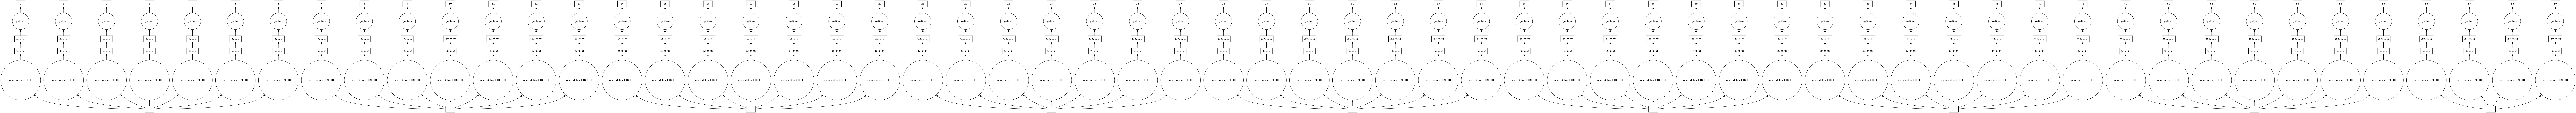

In [21]:
tref_boulder.data.visualize()

<div class="alert alert-block alert-info" markdown="1">
    
**Tip:** Double-click the visualization to view it in full resolution. A file should also be created in your current directory called *mydask.png*.
</div>

We aren't finished constructing our task graph however. Let's add on resampling and mean operation to compute the yearly average. Even though we are defining new intermediate variables, these actions will be added to the original task graph. The intermediate variables will remain dask arrays, even when we trigger a computation on the final variable!

In [22]:
tb_mean = tref_boulder.resample(time='YS').mean()
tb_mean

<xarray.DataArray 'TREFHT' (time: 87)>
dask.array<groupby_nanmean, shape=(87,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 40.05
    lon      float64 0.0
  * time     (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

Finally, let's plot our result. Since we now need values to satisfy the requested action, this triggers a compute step implicitly. What do you notice in the Dashboard panes?

CPU times: user 1.06 s, sys: 102 ms, total: 1.17 s
Wall time: 15.9 s


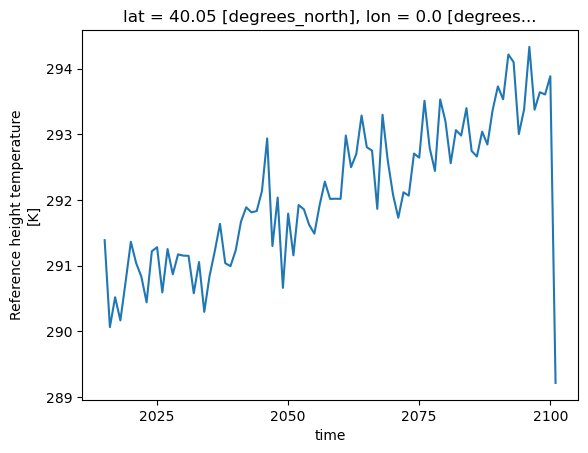

In [23]:
%%time
tb_mean.plot()

#### Adding more workers to reduce time to solution

Unlike on your local machine, Dask clusters on HPC systems and cloud platforms can be expanded - typically the only limitation is how much allocation and/or $$$ you wish to spend.

Scaling your cluster is trivial. Simply rerun the `.scale()` method on your cluster object:

In [24]:
cluster.scale(4)
cluster.wait_for_workers(4)

Now, let's rerun our previous computation and look at the *wall time* difference:

In [25]:
%%time
tb_mean.compute();

CPU times: user 740 ms, sys: 83.8 ms, total: 824 ms
Wall time: 7.73 s


Hopefully you see a roughly 50% reduction in wall time elapsed, which is exactly what we'd expect in this case when doubling workers. We are processing four chunks at any one moment whereas before we could ony process two.

<div class="alert alert-block alert-warning" markdown="1">

**WARNING:** When scaling up a cluster that already has running workers, be aware that the older workers will have less scheduler wall-clock remaining compared to the new workers.

</div>

In [26]:
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
9387540.casper* vanderwb htc      STDIN       39881   1   1   10gb 02:00 R 00:14
9387572.casper* vanderwb htc      dask-esds*  41986   1   1    4gb 01:00 R 00:03
9387573.casper* vanderwb htc      dask-esds*  58697   1   1    4gb 01:00 R 00:03
9387589.casper* vanderwb htc      dask-esds*  23529   1   1    4gb 01:00 R 00:00
9387590.casper* vanderwb htc      dask-esds*  23568   1   1    4gb 01:00 R 00:00

Cached at: Thu 18 Jan 2024 10:58:35 PM MST


## Optimizing and Debugging Dask

### Optimization: Persisting Data

If you need to compute multiple parameters from a Dask collection, it may make sense to store intermediate data in worker memory to avoid repeating early steps in the task graph.

Consider the following example in which we wish to calculate two different time means in the same lat-lon box:

In [27]:
%%time
print("Summer average = {}".format(ds.TREFHT.sel(lat = slice(20, 40), lon = slice(200, 240), time=ds['time.season']=='JJA').mean().compute().data))
print("Winter average = {}".format(ds.TREFHT.sel(lat = slice(20, 40), lon = slice(200, 240), time=ds['time.season']=='DJF').mean().compute().data))

Summer average = 295.2286376953125
Winter average = 291.92706298828125
CPU times: user 1.14 s, sys: 57.2 ms, total: 1.2 s
Wall time: 14.6 s


In [28]:
%%time
subset = ds.TREFHT.sel(lat = slice(20, 40), lon = slice(200, 240)).persist()
print("Summer average = {}".format(subset.sel(time = subset['time.season']=='JJA').mean().compute().data))
print("Winter average = {}".format(subset.sel(time = subset['time.season']=='DJF').mean().compute().data))

Summer average = 295.2286376953125
Winter average = 291.92706298828125
CPU times: user 633 ms, sys: 33.5 ms, total: 667 ms
Wall time: 6.94 s


Of course, when persisting data it is extra important to clean up. Running `del` on your persisted client variable will clear those data from worker memory (*as long as they are not referenced by other variables*). The **progress** dashboard is a useful reminder that we have data persisted.

In [29]:
del(subset)

### Optimization: Choosing Chunk Sizes

Thus far we have left Xarray to decide our Dask chunk sizes. As mentioned, `open_mfdataset` will typically create a chunk for each file. But we can manually specify chunk sizes too.

The chunk size can be quite impactful on performance.

#### Load balancing vs. Overhead

There is always an optimal chunk size given your hardware setup and computational problem. Finding this chunk size often requires some trial and error, but it is helpful to know what you are looking to avoid:

* **Too small** - if your chunks are too small, you will end up spending a significant and wasteful amount of time waiting for Dask to perform overhead (scheduling tasks, data communication) relative to the time spent computing
* **Too large** - you run the risk of spilling to disk or memory failures and the scheduler also has a more difficult time load balancing

The following rules of thumb are known, but it will vary according to your workflow:

|Too Small|Possibly Too Small|Optimal|Too Large|
|-|-|-|-|
|< 1 MB|1-100 MB|100 MB - 1 GB|> Spill threshold|

In practice, using chunks close to 0.1-0.5 GB (or >= 1 million elements) in size works well.

<div class="alert alert-block alert-info" markdown="1">
    
**Tip:** Remember that Dask collection HTML representations provide chunk memory footprint
</div>

#### Matching file chunking

Data formats like HDF5 and NetCDF4 are themselves chunked. If you are using a chunked data format, it is best to specify Dask chunks which equal to or (better-yet) multiples of the chunk shape on disk.

To demonstrate this principle, we will examine a model forecast dataset over the Arctic which is stored in NetCDF format.

In [30]:
file = '/glade/campaign/collections/rda/data/ds631.1/asr15.fcst3.3D/asr15km.fct.3D.20120916.nc'

In [40]:
# Open dataset using auto-chunking as we have done before
ds = xr.open_dataset(file, chunks = 'auto')

Xarray exposes both the collection chunk sizes and the file chunk sizes. Let's compare both to see if our specification is appropriate:

In [41]:
# Print collection chunk sizes
ds.CLDFRA.data

dask.array<open_dataset-CLDFRA, shape=(8, 34, 720, 720), dtype=float32, chunksize=(2, 32, 710, 710), chunktype=numpy.ndarray>

In [42]:
# Print file chunk sizes
ds.CLDFRA.encoding['chunksizes']

(1, 16, 355, 355)

The automatically-generated chunk sizes are multiples of the file chunks. They are also within the suggested ideal memory footprint.

To benchmark performance, we will find the maximum cloud fraction across vertical levels at all locations and times.

In [44]:
%%time
result = ds.CLDFRA.max(dim = "num_metgrid_levels").compute()

CPU times: user 153 ms, sys: 18.6 ms, total: 171 ms
Wall time: 1.33 s


Let's impose chunks that evenly divide into the dimension sizes of the whole array. This may be reasonable in other contexts, but it violates our aforementioned rules.

In [45]:
# Open dataset using divisible chunks
ds = xr.open_dataset(file, chunks = { 'Time' : 8, 'num_metgrid_levels' : 17,
                                      'south_north' : 360, 'east_west' : 360 })

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "south_north" starting at index 360. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "num_metgrid_levels" starting at index 17. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [46]:
# Print collection chunk sizes
ds.CLDFRA.data

dask.array<open_dataset-CLDFRA, shape=(8, 34, 720, 720), dtype=float32, chunksize=(8, 17, 360, 355), chunktype=numpy.ndarray>

In [48]:
%%time
result = ds.CLDFRA.max(dim = "num_metgrid_levels").compute()

CPU times: user 167 ms, sys: 14.4 ms, total: 181 ms
Wall time: 2.06 s


This shows how performance can degrade with poor chunk size choice. Fortunately, Xarray has gotten much better with this recently. The `UserWarning` provided accurate guidance on a potential issue. Auto-chunking also worked well here, which wasn't always the case with older Xarray versions.

<div class="alert alert-block alert-info" markdown="1">
    
**Tip:** Keep the packages you are using up-to-date if you manage your own environment!
</div>

### Dask + Xarray Good Practices

<div class="alert alert-success fade show" markdown="1">

* Similar to Dask DataFrames, it is more efficient to first do spatial and temporal indexing (e.g. .sel() or .isel()) and filter the dataset early in the pipeline, especially before calling resample() or groupby(). 

* Chunk sizes should be small enough to fit into the memory at once but large enough to avoid the additional communication overhead. Good chunk size ~100 MB. 

* It is always better to chunk along the `time` dimension. 

* When possible, use `xr.apply_ufunc` to apply an unvectorized function to the Xarray object. 

</div>

### Debugging Dask case study: memory and spill-to-disk

In this section, we will demonstrate two common considerations when using Dask on HPC:
* Dask data spilling to disk
* Interacting with `dask.distributed` worker logs

For this case study, we will generate progressively larger Dask arrays that eventually trigger memory conditions. Dask workers handle data in different ways in the following memory regimes:

|Suggested Threshold|Case Study Value|Worker Behavior|
|-|-|-|
|0.6 (managed mem)|2.4 GB|Data is allocated on disk (spill)|
|0.7 (process mem)|2.8 GB|Data is allocated on disk (spill)|
|0.8|3.2 GB|New data allocation is paused|
|0.95|3.8 GB|Worker is killed to avoid OOM|

These thresholds can be set at cluster creation time or overridden by your Dask Distributed configuration file.

In [49]:
import dask.array as da
from distributed.worker import logger

It is possible to write directly to worker logs (PBS job logs in our case) using the worker `logger` from Dask Distributed. Here, we define a function to call the logger on each worker, which we will run eagerly via `client.run`.

Keep an eye on the worker memory Dashboard panel as our for loop proceeds...

In [50]:
def log_message(chunk_size):
    logger.info("Current chunk size = {} MiB".format(chunk_size))

In [51]:
for chunk_mib in [1600, 2400, 3200, 3900]:
    client.run(log_message, chunk_mib)
    chunk_size = chunk_mib / 8 * 1024 * 1024
    print("Mean of {} MiB random array = {:0.2f}".format(chunk_mib, da.random.random((chunk_size * 4), chunks=(chunk_size)).mean().compute()))

Mean of 1600 MiB random array = 0.50
Mean of 2400 MiB random array = 0.50
Mean of 3200 MiB random array = 0.50


KilledWorker: Attempted to run task ('random_sample-mean_chunk-99654646aba5eea9bc86de5a5d3951e6', 2) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://128.117.208.112:43081. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [52]:
# List the most recent 4 worker logs - these should be our logs
!ls -lrt dask-logs | tail -n 4

-rw-r--r-- 1 vanderwb csgteam  9840 Jan 18 23:01 9387572.casper-pbs.ER
-rw-r--r-- 1 vanderwb csgteam  9733 Jan 18 23:01 9387589.casper-pbs.ER
-rw-r--r-- 1 vanderwb csgteam  9840 Jan 18 23:01 9387573.casper-pbs.ER
-rw-r--r-- 1 vanderwb csgteam  9733 Jan 18 23:01 9387590.casper-pbs.ER


We can open the log file in the Lab interface or a terminal and investigate the reason for the `KilledWorker` exception.

## Shutting down Dask
Whenever you are done with Dask, you should always shut down the cluster. This ends worker jobs, saving you allocation and freeing up those resources for other users. It also helps minimize the number of ports occupied by Dask clusters.

In [53]:
client.shutdown()

## Summary - When to use Dask?

Dask is a very powerful tool for parallelizing data science. That said, any time you introduce parallelism into your work, the complexity of data flows and the difficulty in debugging problems increases.

**Use Dask:**
* When you have large datasets that don't fit into memory on a single machine.
* When you need to perform parallel computations, such as big data analysis. 

**Avoid Dask:**
* When you have small datasets that can be processed efficiently on a single machine.
* When you don't need parallel processing, as the overhead of managing a distributed computing environment may not be worth the benefits.
* When you need to debug or troubleshoot problems, as distributed computing environments can be challenging for debugging. If the problem is complex, using Dask may make debugging more difficult.

## Resources and references

### Reference
*  [Dask Array Docs](https://docs.dask.org/en/stable/array.html)
*  [Dask Examples](https://examples.dask.org/)
*  [Dask Code](https://github.com/dask/dask/)
*  [Dask Blog](https://blog.dask.org/)
*  [Xarray Docs](https://xarray.pydata.org/)
*  [Xarray + Dask docs](https://docs.xarray.dev/en/stable/user-guide/dask.html), particularly the [optimization tips](https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips)
* [Xarray Tutorial material](https://tutorial.xarray.dev/intro.html)
  

### Ask for help
*   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
*   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
*   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
*   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
*   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests

## Supplemental Material

### Adaptive Cluster Scaling

For interactive, exploratory work, *[adaptive scaling](https://docs.dask.org/en/stable/how-to/adaptive.html)* can be useful (also very useful on cloud platforms). This allows the cluster to dynamically scale up and down based on the (Dask) scheduler's estimation of resource needs. This capability is highly customizable, but one basic method would be to set bounds on the number of worker jobs that can be used:

```
cluster.adapt(minimum=0, maximum=12)
```

Another benefit of adaptive scaling is that you can use the worker `--lifetime` argument to tell Dask to cleanly end work on a worker and restart the PBS job. If you stagger the start of your workers, Dask will be able to shuffle tasks appropriately to produce a so-called *[infinite workload](https://jobqueue.dask.org/en/latest/advanced-tips-and-tricks.html#how-to-handle-job-queueing-system-walltime-killing-workers)*.

On busy systems, adaptive scaling can slow down bursty computations because of queue waits between scale-down and scale-up cycles.

### Dask configuration files

We can customize the behavior of Dask using YAML-based configuration files. These have some advantages:

* Eliminate user-specific configuration from your notebooks/scripts
* Avoid repetition in defining clusters and other Dask objects
* Potentially reduce errors from forgetting important settings

And also some downsides:

* Obfuscates settings from others (including your future self!)
* Reduces portability and ease of debugging

User configuration files are stored in `~/.config/dask` by default. System administrators may also provide default Dask configuration in `/etc/dask` or via the `DASK_ROOT_CONFIG` environment variable.

In [54]:
!ls ~/.config/dask

jobqueue.yaml  labextension.yaml


In [55]:
# Programmatically view configuration file(s) within Python
from dask import config
config.refresh()
config.get('jobqueue.pbs')

{'name': 'dask-worker',
 'cores': None,
 'memory': None,
 'processes': None,
 'interface': None,
 'death-timeout': 60,
 'local-directory': None,
 'shared-temp-directory': None,
 'extra': None,
 'worker-extra-args': [],
 'shebang': '#!/usr/bin/env bash',
 'queue': None,
 'account': None,
 'walltime': '00:30:00',
 'env-extra': None,
 'job-script-prologue': [],
 'resource-spec': None,
 'job-extra': None,
 'job-extra-directives': [],
 'job-directives-skip': [],
 'log-directory': None,
 'scheduler-options': {}}